# HW2P2: Face Classification and Verification


Congrats on coming to the second homework in 11785: Introduction to Deep Learning. This homework significantly longer and tougher than the previous homework. You have 2 sub-parts as outlined below. Please start early! 


*   Face Recognition: You will be writing your own CNN model to tackle the problem of classification, consisting of 7000 identities
*   Face Verification: You use the model trained for classification to evaluate the quality of its feature embeddings, by comparing the similarity of known and unknown identities

Common errors which you may face in this homeworks (because of the size of the model)


*   CUDA Out of Memory (OOM): You can tackle this problem by (1) Reducing the batch size (2) Calling `torch.cuda.empty_cache()` and `gc.collect()` (3) Finally restarting the runtime



# Preliminaries

In [ ]:
!nvidia-smi # to see what GPU you have

In [ ]:
!pip install wandb --quiet
!pip install pytorch_warmup
!pip install timm

In [33]:
import torch
import torch.nn.functional as F
import pytorch_warmup as warmup
from torchsummary import summary
from timm.models.registry import register_model
from timm.models.layers import trunc_normal_, DropPath
import torchvision #This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [4]:
from google.colab import drive # Link your drive if you are a colab user
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it her

Mounted at /content/drive


# TODOs
As you go, please read the code and keep an eye out for TODOs!

# Download Data from Kaggle

In [ ]:
# TODO: Use the same Kaggle code from HW1P2
# !pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8

!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    # Put your kaggle username & key here
    f.write('{"username":"jasongao0917","key":"9aaf0189605045a47217ffc7b87d06fc"}') 

!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!mkdir '/content/data'
!kaggle competitions download -c 11-785-s23-hw2p2-classification
!unzip -qo '11-785-s23-hw2p2-classification.zip' -d '/content/data'

100% 1.71G/1.72G [01:15<00:00, 25.5MB/s]
100% 1.72G/1.72G [01:15<00:00, 24.3MB/s]


In [7]:
!kaggle competitions download -c 11-785-s23-hw2p2-verification
!unzip -qo '11-785-s23-hw2p2-verification.zip' -d '/content/data'

 95% 16.0M/16.8M [00:01<00:00, 17.9MB/s]
100% 16.8M/16.8M [00:01<00:00, 9.98MB/s]


# Configs

The initial learning rate is set to 1e-3 after a series of testing. 1e-1 and 1e-2 are both problematic since both of them lead to NaN values in train loss. If the learning rate is set to a smaller value of 1e-4, the model will even have a hard time to converge. Thus 1e-3 is chosen. The batch size is set to 512. The number of epochs is set to 100.

In [8]:
config = {
    'batch_size': 512, # Increase this if your GPU can handle it
    'lr': 0.001,
    'epochs': 100, # 10 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    # Include other parameters as needed.
}

# Classification Dataset

In terms of the transformation of the training data, after a series of experiments, the following are chosen: 
<br>torchvision.transforms.RandomHorizontalFlip(0.5): randomly flips the picture horizontally with .5 probability
<br>torchvision.transforms.RandAugment(5): removes any learning techniques and proxy tasks to find optimal augmentations
<br>torchvision.transforms.ColorJitter(0.2, 0.2, 0.2): changes the brightness, contrast, saturation and hue of an image
<br>torchvision.transforms.RandomRotation(10): rotates an image by 10 degree
<br>torchvision.transforms.RandomGrayscale(0.05): converts an image to grayscale with a probability of .05
<br>torchvision.transforms.ToTensor(),
<br>torchvision.transforms.RandomErasing(scale=(0.1, 0.1)),
<br>torchvision.transforms.Normalize([0.5116102343520815, 0.4026152878292903, 0.3518579435289671], [0.27100217268019916, 0.23619649639659163, 0.22259977951743307]): these numbers are based on calculations of mean and standard deviation of images in the original training set

In [35]:
DATA_DIR    = '/content/data/11-785-s23-hw2p2-classification/'# TODO: Path where you have downloaded the data
TRAIN_DIR   = os.path.join(DATA_DIR, "train") 
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

# Transforms using torchvision - Refer https://pytorch.org/vision/stable/transforms.html

train_transforms = torchvision.transforms.Compose([
    # torchvision.transforms.RandAugment(5),
    # torchvision.transforms.ColorJitter(0.2, 0.2, 0.2),
    # torchvision.transforms.RandomRotation(10),
    # torchvision.transforms.RandomGrayscale(0.05),
    # torchvision.transforms.RandomApply([torchvision.transforms.RandAugment(magnitude=9)], 0.5),
    # torchvision.transforms.ToTensor(),
    # torchvision.transforms.RandomErasing(p=0.1),
    # torchvision.transforms.Normalize([0.38713345888689044, 0.20228348739997548, 0.1282108154279697], [0.990333481067632, 0.9382020029235498, 0.9284910007525901]),
    # torchvision.transforms.RandomHorizontalFlip(0.5),
    # torchvision.transforms.RandAugment(5),
    # torchvision.transforms.ColorJitter(0.2, 0.2, 0.2),
    # torchvision.transforms.RandomGrayscale(0.05),
    # torchvision.transforms.RandomRotation(10),
    # torchvision.transforms.RandomErasing(p=0.1),
    # torchvision.transforms.RandomApply([torchvision.transforms.RandAugment(magnitude=9)], 0.5), 
    # torchvision.transforms.ToTensor(),
    # torchvision.transforms.RandomErasing(p=0.1),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandAugment(5),
    torchvision.transforms.ColorJitter(0.2, 0.2, 0.2),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.RandomGrayscale(0.05),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomErasing(scale=(0.1, 0.1)),
    torchvision.transforms.Normalize([0.5116102343520815, 0.4026152878292903, 0.3518579435289671], [0.27100217268019916, 0.23619649639659163, 0.22259977951743307]),
])# Implementing the right train transforms/augmentation methods is key to improving performance.

# Most torchvision transforms are done on PIL images. So you convert it into a tensor at the end with ToTensor()
# But there are some transforms which are performed after ToTensor() : e.g - Normalization
# Normalization Tip - Do not blindly use normalization that is not suitable for this dataset

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5116102343520815, 0.4026152878292903, 0.3518579435289671], [0.27100217268019916, 0.23619649639659163, 0.22259977951743307]),
])


train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform= valid_transforms)
# You should NOT have data augmentation on the validation set. Why?


# Create data loaders
train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset, 
    batch_size  = config['batch_size'], 
    shuffle     = True,
    num_workers = 4, 
    pin_memory  = True
)

valid_loader = torch.utils.data.DataLoader(
    dataset     = valid_dataset, 
    batch_size  = config['batch_size'],
    shuffle     = False,
    num_workers = 2
)

In [36]:
# You can do this with ImageFolder as well, but it requires some tweaking
class ClassificationTestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

In [37]:
test_dataset = ClassificationTestDataset(TEST_DIR, transforms = valid_transforms) #Why are we using val_transforms for Test Data?
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = config['batch_size'], shuffle = False,
                         drop_last = False, num_workers = 2)

In [38]:
print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

Number of classes    :  7000
No. of train images  :  140000
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  512
Train batches        :  274
Val batches          :  69


## Data visualization

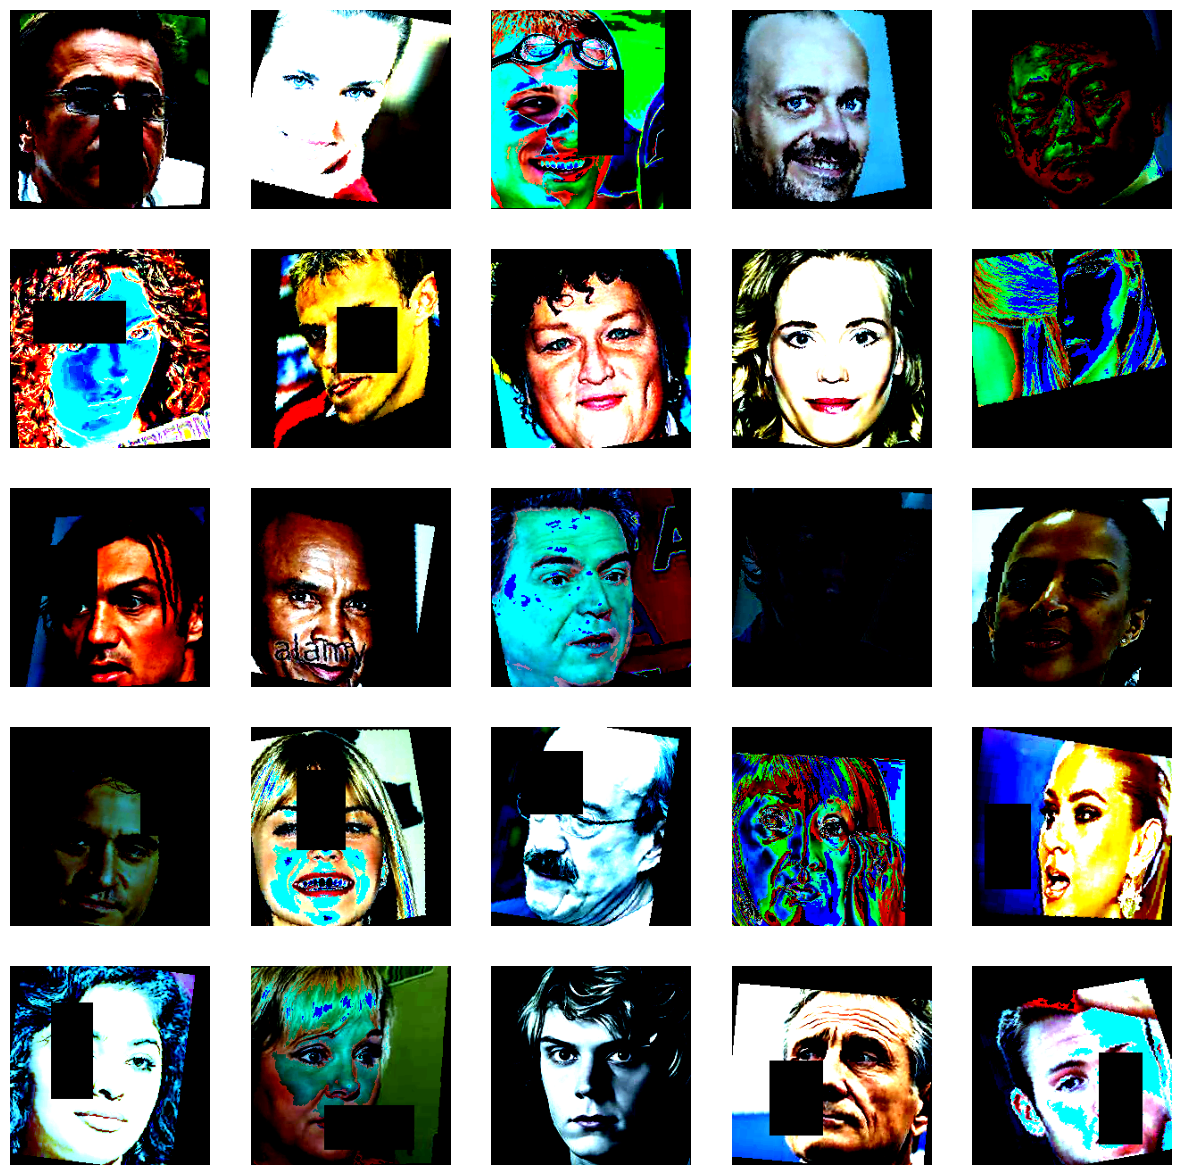

In [39]:
# Visualize a few images in the dataset
# You can write your own code, and you don't need to understand the code
# It is highly recommended that you visualize your data augmentation as sanity check

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'], 
    shuffle     = True,
)

for data in dtl:
    x, y = data
    
    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Very Simple Network (for Mandatory Early Submission)

In [23]:
class Network(torch.nn.Module):
  def __init__(self, dim, drop_rate):
    super(Network, self).__init__()
    self.drop_path = torch.nn.Sequential(
        torchvision.ops.StochasticDepth(p=drop_rate, mode='row')
    )
    # creates three different convolutional layers
    self.convolute1 = torch.nn.Conv2d(dim, dim, kernel_size = 7, padding = 3, groups = dim)
    self.convolute2 = torch.nn.Conv2d(dim, dim * 4, kernel_size = 1)
    self.convolute3 = torch.nn.Conv2d(dim * 4, dim, kernel_size=1)
    # creates batchnorm 
    self.normalize = torch.nn.BatchNorm2d(dim)
    # uses GELU as the activation function
    self.activate = torch.nn.GELU()

  def forward(self, x):
    identity = x
    x = self.convolute1(x)
    x = self.normalize(x)
    x = self.convolute2(x)
    x = self.activate(x)
    x = self.convolute3(x)
    x = self.drop_path(x)
    x += identity

    return x

In [48]:
class ConvNet(torch.nn.Module):
    def __init__(self, num_classes = 7000, depths = [3, 3, 9, 3], dims = [96, 192, 384, 768]):
        super().__init__()
        drop_rate_vals = torch.linspace(0, 0.1, 18)
        drop_rates = []
        for val in drop_rate_vals:
          drop_rates.append(val.item())
        # utilizes Network class in a sequantial training  
        self.layers = torch.nn.Sequential(
          torch.nn.Conv2d(3, dims[0], kernel_size=4, stride=4),
          torch.nn.BatchNorm2d(dims[0]),
          Network(dims[0], drop_rate=drop_rates[0]),
          Network(dims[0], drop_rate=drop_rates[1]),
          Network(dims[0], drop_rate=drop_rates[2]),

          torch.nn.BatchNorm2d(dims[0]),
          torch.nn.Conv2d(dims[0], dims[1], kernel_size=2, stride=2),
          Network(dims[1], drop_rate=drop_rates[3]),
          Network(dims[1], drop_rate=drop_rates[4]),
          Network(dims[1], drop_rate=drop_rates[5]),

          torch.nn.BatchNorm2d(dims[1]),
          torch.nn.Conv2d(dims[1], dims[2], kernel_size=2, stride=2),
          Network(dims[2], drop_rate=drop_rates[6]),
          Network(dims[2], drop_rate=drop_rates[7]),
          Network(dims[2], drop_rate=drop_rates[8]),
          Network(dims[2], drop_rate=drop_rates[9]),
          Network(dims[2], drop_rate=drop_rates[10]),
          Network(dims[2], drop_rate=drop_rates[11]),
          Network(dims[2], drop_rate=drop_rates[12]),
          Network(dims[2], drop_rate=drop_rates[13]),
          Network(dims[2], drop_rate=drop_rates[14]),

          torch.nn.BatchNorm2d(dims[2]),
          torch.nn.Conv2d(dims[2], dims[3], kernel_size=2, stride=2),
          Network(dims[3], drop_rate=drop_rates[15]),
          Network(dims[3], drop_rate=drop_rates[16]),
          Network(dims[3], drop_rate=drop_rates[17])
          )
        
        # uses adaptive averaeg pooling 
        self.AvgPool = torch.nn.AdaptiveAvgPool2d((1,1))
        
        # linear layer to classify the images
        self.cls_layer = torch.nn.Linear(dims[-1], num_classes)
    
    def forward(self, x, return_feats=False):
      feats = self.layers(x)
      feats = self.AvgPool(feats)
      feats = feats.reshape(-1, 768)
      out = self.cls_layer(feats)

      if return_feats == True:
        return feats
      else:
        return out

In [41]:
model = ConvNet().to(DEVICE)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       BatchNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
       BatchNorm2d-4           [-1, 96, 56, 56]             192
            Conv2d-5          [-1, 384, 56, 56]          37,248
              GELU-6          [-1, 384, 56, 56]               0
            Conv2d-7           [-1, 96, 56, 56]          36,960
   StochasticDepth-8           [-1, 96, 56, 56]               0
           Network-9           [-1, 96, 56, 56]               0
           Conv2d-10           [-1, 96, 56, 56]           4,800
      BatchNorm2d-11           [-1, 96, 56, 56]             192
           Conv2d-12          [-1, 384, 56, 56]          37,248
             GELU-13          [-1, 384, 56, 56]               0
           Conv2d-14           [-1, 96,

# Setup everything for training

In [42]:
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # TODO: What loss do you need for a multi class classification problem?
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
# TODO: Implement a scheduler (Optional but Highly Recommended)
# You can try ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 3, verbose = True)
scaler = torch.cuda.amp.GradScaler() # Good news. We have FP16 (Mixed precision training) implemented for you
# It is useful only in the case of compatible GPUs such as T4/V100

# Let's train!

In [43]:
def train(model, dataloader, optimizer, criterion):
    
    model.train()

    # Progress Bar 
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5) 

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):
        
        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it! 
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )
        
        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update() 

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?
      
        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [44]:
def validate(model, dataloader, criterion):
  
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):
        
        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()
        
    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [45]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Wandb

In [46]:
wandb.login(key="06c8f81427188d28de31ac7bfe0ddeadd005abc3") #API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [47]:
# Create your wandb run
run = wandb.init(
    name = "submission-20", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

# Experiments

Running with initial hyperparameters for 100 epochs will get the validation accuracy to about 85%. After that, save the current model train with 1e-3 as learning rate for 20 epochs to let validation accuracy get higher. Repeat the 20-epoch training for 3-4 times so that the validation accuracy will approach about 87%. Lastly, to have final accuracy surpass 90%, we train the model with images in the validation set.

In [ ]:
# model.load_state_dict(torch.load("/content/model11"))

<All keys matched successfully>

In [ ]:
best_valacc = 0.0

for epoch in range(config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    
    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_acc,
        train_loss,
        curr_lr))
    
    val_acc, val_loss = validate(model, valid_loader, criterion)
    
    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))
    scheduler.step(val_loss)

    wandb.log({"train_loss":train_loss, 'train_Acc': train_acc, 'validation_Acc':val_acc, 
               'validation_loss': val_loss, "learning_Rate": curr_lr})
    
    # If you are using a scheduler in your train function within your iteration loop, you may want to log
    # your learning rate differently 

    # #Save model in drive location if val_acc is better than best recorded val_acc
    if val_acc >= best_valacc:
      #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
      print("Saving model")
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  #'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': val_acc, 
                  'epoch': epoch}, './checkpoint.pth')
      best_valacc = val_acc
      wandb.save('checkpoint.pth')
      # You may find it interesting to exlplore Wandb Artifcats to version your models
run.finish()

In [ ]:
# torch.save(model.state_dict(), "model2")

# Classification Task: Testing

In [ ]:
def test(model,dataloader):

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []
  
  for i, (images) in enumerate(dataloader):
      # TODO: Finish predicting on the test set.
      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)
      
      batch_bar.update()
      
  batch_bar.close()
  return test_results

In [ ]:
test_results = test(model, test_loader)

## Generate csv to submit to Kaggle

In [ ]:
with open("submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(5) + ".jpg", test_results[i]))

In [ ]:
!kaggle competitions submit -c 11-785-s23-hw2p2-classification -f submission.csv -m "Message"

100% 507k/507k [00:02<00:00, 202kB/s]
Successfully submitted to Face Classification

# Verification Task: Validation

The verification task consists of the following generalized scenario:
- You are given X unknown identitites 
- You are given Y known identitites
- Your goal is to match X unknown identities to Y known identities.

We have given you a verification dataset, that consists of 960 known identities, and 1080 unknown identities. The 1080 unknown identities are split into dev (360) and test (720). Your goal is to compare the unknown identities to the 1080 known identities and assign an identity to each image from the set of unknown identities. Some unknown identities do not have correspondence in known identities, you also need to identify these and label them with a special label n000000.

Your will use/finetune your model trained for classification to compare images between known and unknown identities using a similarity metric and assign labels to the unknown identities. 

This will judge your model's performance in terms of the quality of embeddings/features it generates on images/faces it has never seen during training for classification.

In [ ]:
# This obtains the list of known identities from the known folder
known_regex = "/content/data/11-785-s23-hw2p2-verification/known/*/*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
unknown_dev_regex = "/content/data/11-785-s23-hw2p2-verification/unknown_dev/*"
unknown_test_regex = "/content/data/11-785-s23-hw2p2-verification/unknown_test/*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6) 

100%|██████████| 960/960 [00:00<00:00, 14200.48it/s]


In [ ]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'): 

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size
        
        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(DEVICE), return_feats=True) #Get features from model         
        unknown_feats.append(unknown_feat)
        batch_bar.update()
    
    batch_bar.close()
    
    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    
    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size] 
        with torch.no_grad():
              known_feat = model(known_batch.float().to(DEVICE), return_feats=True)
          
        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?

    max_similarity_values, predictions = similarity_values.max(0) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()


    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain 
    # threshold compared with those identities with correspondence.

    # In early submission, you can ignore identities without correspondence, simply taking identity with max similarity value
    pred_id_strings = [known_paths[i] for i in predictions] # Map argmax indices to identity strings
    
    # After early submission, remove the previous line and uncomment the following code 

    threshold = 0.34
    NO_CORRESPONDENCE_LABEL = 'n000000'
    pred_id_strings = []
    for idx, prediction in enumerate(predictions):
      if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
        pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
      else:
        pred_id_strings.append(known_paths[prediction])
    
    if mode == 'val':
      true_ids = pd.read_csv('/content/data/11-785-s23-hw2p2-verification/verification_dev.csv')['label'].tolist()
      accuracy = accuracy_score(pred_id_strings, true_ids)
      print("Verification Accuracy = {}".format(accuracy))
    
    return pred_id_strings

In [ ]:
# verification eval
pred_id_strings = eval_verification(unknown_dev_images, known_images, model, similarity_metric, config['batch_size'], mode='val')
# verification test
pred_id_strings = eval_verification(unknown_test_images, known_images, model, similarity_metric, config['batch_size'], mode='test')

Verification Accuracy = 0.44722222222222224


## Generate csv to submit to Kaggle

In [ ]:
with open("submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))

In [ ]:
!kaggle competitions submit -c 11-785-s23-hw2p2-verification -f submission.csv -m "Message"

100% 8.34k/8.34k [00:02<00:00, 3.65kB/s]
Successfully submitted to Face Verification